In [1]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Training in chronological window subgraph
Downsample 90% normal traffic stratigically
Split train and test subgraph stratigically 

IP as node
Encode Ports in 3 Categories
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [2]:
csv_file_name = "all_raw"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "window_categorical_port"

SOURCE_FILE_ID_COL_NAME = UNSW_NB15_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

CATEGORICAL_COLS = UNSW_NB15_Config.CATEGORICAL_COLS

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

attack_cat
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoors            2329
Shellcode            1511
Worms                 174
Name: count, dtype: int64
label
0    2218764
1     321283
Name: count, dtype: int64


In [3]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [4]:
data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# Port category encoding: 
def port_category(port_str):
    try:
        port_int = int(port_str)
        if 1 <= port_int <= 1023:
            return [1, 0, 0]  # Well Known
        elif 1024 <= port_int <= 49151:
            return [0, 1, 0]  # Registered
        elif 49152 <= port_int <= 65535:
            return [0, 0, 1]  # Dynamic/Private
        else:
            return [0, 0, 0]  # Out of range, encode as all zeros
    except:
        return [0, 0, 0]  # Non-integer or missing, encode as all zeros

# Create new columns for binary encoding
src_port_category = data[SOURCE_PORT_COL_NAME].apply(port_category)
dst_port_category = data[DESTINATION_PORT_COL_NAME].apply(port_category)

src_port_category_df = pd.DataFrame(src_port_category.tolist(), columns=[f"{SOURCE_PORT_COL_NAME}_category_{i}" for i in range(3)])
dst_port_category_df = pd.DataFrame(dst_port_category.tolist(), columns=[f"{DESTINATION_PORT_COL_NAME}_category_{i}" for i in range(3)])

# Concatenate the binary columns to the original dataframe
data = pd.concat([data, src_port_category_df, dst_port_category_df], axis=1)

data.drop(columns=[SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME], inplace=True)

converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]))]

In [5]:
print(data.head)

<bound method NDFrame.head of                      srcip              dstip        dur  sbytes  dbytes  \
0            10.40.182.1_0        224.0.0.5_0  50.004337     384       0   
1             10.40.85.1_0        224.0.0.5_0  50.004341     384       0   
2            10.40.182.1_0        224.0.0.5_0  50.004337     384       0   
3             10.40.85.1_0        224.0.0.5_0  50.004341     384       0   
4        192.168.241.243_0  192.168.241.243_0   0.000000    1780       0   
...                    ...                ...        ...     ...     ...   
2540042       59.166.0.0_3    149.171.126.5_3   0.001035     146     178   
2540043       59.166.0.5_3    149.171.126.3_3   0.220630     424    8824   
2540044       59.166.0.6_3    149.171.126.7_3   0.031576    2646   25564   
2540045       59.166.0.2_3    149.171.126.7_3   0.096835    4862   82782   
2540046       59.166.0.9_3    149.171.126.7_3   0.201886   37552    3380   

         sttl  dttl  sloss  dloss         Sload  ...  sta

In [6]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                      srcip              dstip        dur  sbytes  dbytes  \
0            10.40.182.1_0        224.0.0.5_0  50.004337     384       0   
1             10.40.85.1_0        224.0.0.5_0  50.004341     384       0   
2            10.40.182.1_0        224.0.0.5_0  50.004337     384       0   
3             10.40.85.1_0        224.0.0.5_0  50.004341     384       0   
4        192.168.241.243_0  192.168.241.243_0   0.000000    1780       0   
...                    ...                ...        ...     ...     ...   
2540042       59.166.0.0_3    149.171.126.5_3   0.001035     146     178   
2540043       59.166.0.5_3    149.171.126.3_3   0.220630     424    8824   
2540044       59.166.0.6_3    149.171.126.7_3   0.031576    2646   25564   
2540045       59.166.0.2_3    149.171.126.7_3   0.096835    4862   82782   
2540046       59.166.0.9_3    149.171.126.7_3   0.201886   37552    3380   

         sttl  dttl  sloss  dloss         Sload  ...  sta

In [7]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                dur        sbytes        dbytes          sttl          dttl  \
count  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06   
mean   6.587916e-01  4.339600e+03  3.642759e+04  6.278197e+01  3.076681e+01   
std    1.392493e+01  5.640599e+04  1.610960e+05  7.462277e+01  4.285089e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.037000e-03  2.000000e+02  1.780000e+02  3.100000e+01  2.900000e+01   
50%    1.586100e-02  1.470000e+03  1.820000e+03  3.100000e+01  2.900000e+01   
75%    2.145545e-01  3.182000e+03  1.489400e+04  3.100000e+01  2.900000e+01   
max    8.786638e+03  1.435577e+07  1.465753e+07  2.550000e+02  2.540000e+02   

              sloss         dloss         Sload         Dload         Spkts  \
count  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06   
mean   5.163921e+00  1.632944e+01  3.695645e+07  2.450861e+06  3.328884e+01   
std    2.251707e+01  5.659474e+01  1.186043e+08  4.

In [8]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [9]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [10]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [11]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH', 'state_URN', 'state_no', 'sport_category_0', 'sport_category_1', 'sport_category_2', 'dsport_category_0', 'dsport_category_1', 'dsport_category_2']
Number of Features: 60


In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
import heapq

import tqdm

class Downsampler:
    def __init__(self, downsample_classes=[BENIGN_CLASS_LABEL], downsample_ratios=[0.1]):
        """
        downsample_classes: list of class names to downsample
        downsample_ratio: keep no more than this ratio for each class
        """
        assert len(downsample_classes) == len(downsample_ratios)
        self.downsample_classes = downsample_classes
        self.downsample_ratio = downsample_ratios

    def downsample(self, label_counts_list, X, y):
        total_counts = defaultdict(int)

        class_heaps = defaultdict(list)
        for i, lc in enumerate(label_counts_list):
            for cls in self.downsample_classes:
                class_label_count = lc.get(cls, 0)
                total_counts[cls] += class_label_count
                heapq.heappush(class_heaps[cls], (-class_label_count, i))

        class_target = {
            cls: total_counts[cls] * self.downsample_ratio[i] for i, cls in enumerate(self.downsample_classes)
        }
                
        indices_to_remove = set()
        class_counts = total_counts

        # 3. For each class, remove top contributing samples until threshold reached
        for cls in self.downsample_classes:
            target = class_target[cls]
            heap = class_heaps[cls]

            pbar = tqdm(desc=f"Downsampling '{cls}'", total=len(heap))
            while class_counts[cls] > target and heap:
                _, idx = heapq.heappop(heap)
                if idx in indices_to_remove:
                    continue
                # For each class in this sample, if it's a downsample class, decrement the count
                for sample_cls, count in label_counts_list[idx].items():
                    if sample_cls in self.downsample_classes:
                        class_counts[sample_cls] -= count
                indices_to_remove.add(idx)
                pbar.update(1)
                pbar.set_postfix(class_label=cls, remaining=class_counts[cls], target=target)
            pbar.close()

        # 4. Apply filter
        keep_mask = [i for i in range(len(X)) if i not in indices_to_remove]
        X_new = [X[i] for i in keep_mask]
        y_new = [y[i] for i in keep_mask]

        return X_new, y_new

downsampler = Downsampler()

In [14]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols=[SOURCE_FILE_ID_COL_NAME] + TIME_COLS + [ATTACK_CLASS_COL_NAME], 
    label_col=label_col,
    build_graph_func=create_graph,
    downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    X, y = downsampler.downsample(label_counts_list, X, y)
        
    return StratifiedGraphDataset(X, y)

In [15]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
       'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'attack_cat', 'source_file_id', 'state_ACC', 'state_CLO', 'state_CON',
       'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS',
       'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD',
       'state_URH', 'state_URN', 'state_no', 'sport_category_0',
       'sport_category_1', 'sport_category_2', 'dsport_category_0',
       'dsport_category_1', 'dsport_category_2', 'h'],
      dtype='object')
Ordering Columns:  

Downsampling '6':  85%|████████▌ | 10853/12701 [00:08<00:01, 1332.73it/s, class_label=6, remaining=221852, target=2.22e+5]


In [16]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: attack_cat
6    2218764
5     215481
3      44525
4      24246
2      16353
7      13987
0       2677
1       2329
8       1511
9        174
Name: count, dtype: int64
Number of graphs after downsampling: 1848
Class Counts and Weights:
6   Normal         : Count = 221852    , Weight = 0.1665    
5   Generic        : Count = 105186    , Weight = 0.3512    
3   Exploits       : Count = 17858     , Weight = 2.0688    
0   Analysis       : Count = 2083      , Weight = 17.7363   
1   Backdoors      : Count = 1818      , Weight = 20.3216   
2   DoS            : Count = 11800     , Weight = 3.1309    
4   Fuzzers        : Count = 5177      , Weight = 7.1363    
7   Reconnaissance : Count = 3401      , Weight = 10.8629   
9   Worms          : Count = 41        , Weight = 901.0902  
8   Shellcode      : Count = 231       , Weight = 159.9338  
Number of training graphs: 1570
Class Counts and Weights:
6   Normal         : Count = 188281    , Weight = 0.1667    
5   Generic     

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [21]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [22]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [23]:
import pickle

def save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [24]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 1000

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Number of train graphs:  1334
Class weights: tensor([1.8187e+01, 2.1024e+01, 3.0260e+00, 2.0663e+00, 7.5452e+00, 3.5045e-01,
        1.6674e-01, 1.0824e+01, 1.5976e+02, 8.8933e+02], device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.7748766002952362
Epoch 0, Train Loss: 2.2161, Validation Loss: 8.4484, Validation F1: 0.7749


Epoch 5 Saved best model. Best F1: 0.7885409513438584


Epoch 6 Saved best model. Best F1: 0.87483286680454


Epoch 10 Saved best model. Best F1: 0.8831307998175778
Epoch 10, Train Loss: 1.3923, Validation Loss: 1.1750, Validation F1: 0.8831


Epoch 13 Saved best model. Best F1: 0.8857187223680121


Epoch 14 Saved best model. Best F1: 0.8907938906176842


Epoch 15 Saved best model. Best F1: 0.8959413611607615


Epoch 16 Saved best model. Best F1: 0.9059938942491004


Epoch 20, Train Loss: 0.9293, Validation Loss: 0.8550, Validation F1: 0.8920


Epoch 30, Train Loss: 0.7930, Validation Loss: 0.7530, Validation F1: 0.9030


Epoch 31 Saved best model. Best F1: 0.909583593098634


Epoch 40, Train Loss: 0.7289, Validation Loss: 0.7004, Validation F1: 0.9049


Epoch 50 Saved best model. Best F1: 0.9102210198097188
Epoch 50, Train Loss: 0.6952, Validation Loss: 0.6799, Validation F1: 0.9102


Epoch 60 Saved best model. Best F1: 0.9130705903407764
Epoch 60, Train Loss: 0.6730, Validation Loss: 0.6693, Validation F1: 0.9131


Epoch 62 Saved best model. Best F1: 0.914253367144853


Epoch 70, Train Loss: 0.6548, Validation Loss: 0.6637, Validation F1: 0.9097


Epoch 73 Saved best model. Best F1: 0.9143710147391982


Epoch 80, Train Loss: 0.6514, Validation Loss: 0.6676, Validation F1: 0.9061


Epoch 90, Train Loss: 0.6389, Validation Loss: 0.6549, Validation F1: 0.9118


Epoch 98 Saved best model. Best F1: 0.9146796231290211


Epoch 99 Saved best model. Best F1: 0.915035773996975


Epoch 100, Train Loss: 0.6214, Validation Loss: 0.6460, Validation F1: 0.9092


Epoch 110, Train Loss: 0.6178, Validation Loss: 0.6551, Validation F1: 0.9101


Epoch 120, Train Loss: 0.6087, Validation Loss: 0.6430, Validation F1: 0.9123


Epoch 130, Train Loss: 0.5990, Validation Loss: 0.6402, Validation F1: 0.9076


Epoch 140, Train Loss: 0.5938, Validation Loss: 0.6406, Validation F1: 0.9094


Epoch 150, Train Loss: 0.5809, Validation Loss: 0.6287, Validation F1: 0.9103


Epoch 160, Train Loss: 0.5766, Validation Loss: 0.6388, Validation F1: 0.9136


Epoch 165 Saved best model. Best F1: 0.9157365922093241


Epoch 170, Train Loss: 0.5746, Validation Loss: 0.6389, Validation F1: 0.9142


Epoch 178 Saved best model. Best F1: 0.915750358107429


Epoch 180, Train Loss: 0.5704, Validation Loss: 0.6658, Validation F1: 0.9114


Epoch 187 Saved best model. Best F1: 0.9167381661499706


Epoch 190, Train Loss: 0.5551, Validation Loss: 0.6494, Validation F1: 0.9107


Epoch 200, Train Loss: 0.5491, Validation Loss: 0.6348, Validation F1: 0.9103


Epoch 210, Train Loss: 0.5450, Validation Loss: 0.6312, Validation F1: 0.9078


Epoch 220, Train Loss: 0.5391, Validation Loss: 0.6530, Validation F1: 0.9124


Epoch 227 Saved best model. Best F1: 0.9169291252325


Epoch 228 Saved best model. Best F1: 0.9177277232456751


Epoch 230, Train Loss: 0.5373, Validation Loss: 0.6404, Validation F1: 0.9063


Epoch 240, Train Loss: 0.5334, Validation Loss: 0.6493, Validation F1: 0.9130


Epoch 250, Train Loss: 0.5293, Validation Loss: 0.6606, Validation F1: 0.9130


Epoch 260, Train Loss: 0.5332, Validation Loss: 0.6657, Validation F1: 0.9121


Epoch 267 Saved best model. Best F1: 0.91837301809135


Epoch 270, Train Loss: 0.5277, Validation Loss: 0.6745, Validation F1: 0.9178


Epoch 273 Saved best model. Best F1: 0.9194963238459982


Epoch 280, Train Loss: 0.5155, Validation Loss: 0.6899, Validation F1: 0.9096


Epoch 290, Train Loss: 0.5132, Validation Loss: 0.6477, Validation F1: 0.9161


Epoch 300, Train Loss: 0.5115, Validation Loss: 0.6640, Validation F1: 0.9123


Epoch 310, Train Loss: 0.5059, Validation Loss: 0.6709, Validation F1: 0.9152


Epoch 320, Train Loss: 0.5049, Validation Loss: 0.6812, Validation F1: 0.9089


Epoch 322 Saved best model. Best F1: 0.9197117651156965


Epoch 330, Train Loss: 0.5051, Validation Loss: 0.6950, Validation F1: 0.9114


Epoch 340, Train Loss: 0.5008, Validation Loss: 0.6731, Validation F1: 0.9092


Epoch 350, Train Loss: 0.4980, Validation Loss: 0.6626, Validation F1: 0.9143


Epoch 360, Train Loss: 0.5050, Validation Loss: 0.6704, Validation F1: 0.9164


Epoch 370, Train Loss: 0.4984, Validation Loss: 0.6660, Validation F1: 0.9173


Epoch 380, Train Loss: 0.4912, Validation Loss: 0.7183, Validation F1: 0.9134


Epoch 390, Train Loss: 0.4908, Validation Loss: 0.6637, Validation F1: 0.9100


Epoch 400, Train Loss: 0.4872, Validation Loss: 0.7114, Validation F1: 0.9160


Epoch 410, Train Loss: 0.4860, Validation Loss: 0.6936, Validation F1: 0.9154


Epoch 420, Train Loss: 0.4833, Validation Loss: 0.7240, Validation F1: 0.9142


Epoch 430, Train Loss: 0.4845, Validation Loss: 0.7156, Validation F1: 0.9147


Epoch 440, Train Loss: 0.4802, Validation Loss: 0.7234, Validation F1: 0.9079


Epoch 450, Train Loss: 0.4796, Validation Loss: 0.7024, Validation F1: 0.9104


Epoch 460, Train Loss: 0.4774, Validation Loss: 0.7076, Validation F1: 0.9162


Epoch 470, Train Loss: 0.4744, Validation Loss: 0.7265, Validation F1: 0.9147


Epoch 480, Train Loss: 0.4734, Validation Loss: 0.7394, Validation F1: 0.9183


Epoch 490, Train Loss: 0.4724, Validation Loss: 0.7228, Validation F1: 0.9112


Epoch 500, Train Loss: 0.4713, Validation Loss: 0.7355, Validation F1: 0.9127


Epoch 510, Train Loss: 0.4694, Validation Loss: 0.7499, Validation F1: 0.9142


Epoch 520, Train Loss: 0.4694, Validation Loss: 0.7348, Validation F1: 0.9155


Epoch 530, Train Loss: 0.4680, Validation Loss: 0.7148, Validation F1: 0.9145


Epoch 540, Train Loss: 0.4683, Validation Loss: 0.7007, Validation F1: 0.9150


Epoch 550, Train Loss: 0.4674, Validation Loss: 0.7585, Validation F1: 0.9132


Epoch 560, Train Loss: 0.4638, Validation Loss: 0.7136, Validation F1: 0.9140


Epoch 570, Train Loss: 0.4653, Validation Loss: 0.7642, Validation F1: 0.9160


Epoch 580, Train Loss: 0.4625, Validation Loss: 0.7545, Validation F1: 0.9156


Epoch 590, Train Loss: 0.4632, Validation Loss: 0.7367, Validation F1: 0.9140


Epoch 600, Train Loss: 0.4620, Validation Loss: 0.7432, Validation F1: 0.9163


Epoch 610, Train Loss: 0.4631, Validation Loss: 0.7846, Validation F1: 0.9152


Epoch 620, Train Loss: 0.4597, Validation Loss: 0.7557, Validation F1: 0.9171


Epoch 630, Train Loss: 0.4603, Validation Loss: 0.7687, Validation F1: 0.9144


Epoch 640, Train Loss: 0.4579, Validation Loss: 0.7673, Validation F1: 0.9147


Epoch 650, Train Loss: 0.4593, Validation Loss: 0.7556, Validation F1: 0.9168


Epoch 660, Train Loss: 0.4561, Validation Loss: 0.7837, Validation F1: 0.9134


Epoch 670, Train Loss: 0.4584, Validation Loss: 0.7707, Validation F1: 0.9144


Epoch 680, Train Loss: 0.4568, Validation Loss: 0.7782, Validation F1: 0.9136


Epoch 690, Train Loss: 0.4572, Validation Loss: 0.7741, Validation F1: 0.9166


Epoch 700, Train Loss: 0.4550, Validation Loss: 0.7988, Validation F1: 0.9159


Epoch 710, Train Loss: 0.4561, Validation Loss: 0.7669, Validation F1: 0.9160


Epoch 720, Train Loss: 0.4575, Validation Loss: 0.7919, Validation F1: 0.9165


Epoch 730, Train Loss: 0.4553, Validation Loss: 0.7950, Validation F1: 0.9175


Epoch 740, Train Loss: 0.4563, Validation Loss: 0.7982, Validation F1: 0.9184


Epoch 750, Train Loss: 0.4539, Validation Loss: 0.7826, Validation F1: 0.9159


Epoch 760, Train Loss: 0.4526, Validation Loss: 0.7821, Validation F1: 0.9179


Epoch 770, Train Loss: 0.4531, Validation Loss: 0.7846, Validation F1: 0.9155


Epoch 780, Train Loss: 0.4523, Validation Loss: 0.8132, Validation F1: 0.9160


Epoch 790, Train Loss: 0.4528, Validation Loss: 0.7911, Validation F1: 0.9159


Epoch 800, Train Loss: 0.4519, Validation Loss: 0.7681, Validation F1: 0.9176


Epoch 810, Train Loss: 0.4505, Validation Loss: 0.7959, Validation F1: 0.9152


Epoch 820, Train Loss: 0.4516, Validation Loss: 0.8030, Validation F1: 0.9154


Epoch 830, Train Loss: 0.4511, Validation Loss: 0.8140, Validation F1: 0.9165


Epoch 840, Train Loss: 0.4511, Validation Loss: 0.7537, Validation F1: 0.9159


Epoch 850, Train Loss: 0.4529, Validation Loss: 0.7821, Validation F1: 0.9159


Epoch 860, Train Loss: 0.4519, Validation Loss: 0.7526, Validation F1: 0.9157


Epoch 870, Train Loss: 0.4512, Validation Loss: 0.8030, Validation F1: 0.9165


Epoch 880, Train Loss: 0.4512, Validation Loss: 0.8056, Validation F1: 0.9156


Epoch 890, Train Loss: 0.4518, Validation Loss: 0.7907, Validation F1: 0.9169


Epoch 900, Train Loss: 0.4498, Validation Loss: 0.7965, Validation F1: 0.9150


Epoch 910, Train Loss: 0.4502, Validation Loss: 0.8130, Validation F1: 0.9151


Epoch 920, Train Loss: 0.4493, Validation Loss: 0.7772, Validation F1: 0.9157


Epoch 930, Train Loss: 0.4502, Validation Loss: 0.7680, Validation F1: 0.9171


Epoch 940, Train Loss: 0.4517, Validation Loss: 0.7781, Validation F1: 0.9158


Epoch 950, Train Loss: 0.4517, Validation Loss: 0.8188, Validation F1: 0.9154


Epoch 960, Train Loss: 0.4500, Validation Loss: 0.7913, Validation F1: 0.9173


Epoch 970, Train Loss: 0.4500, Validation Loss: 0.7960, Validation F1: 0.9169


Epoch 980, Train Loss: 0.4509, Validation Loss: 0.8080, Validation F1: 0.9165


Epoch 990, Train Loss: 0.4505, Validation Loss: 0.7702, Validation F1: 0.9157


Model training completed and saved.


In [25]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

1000


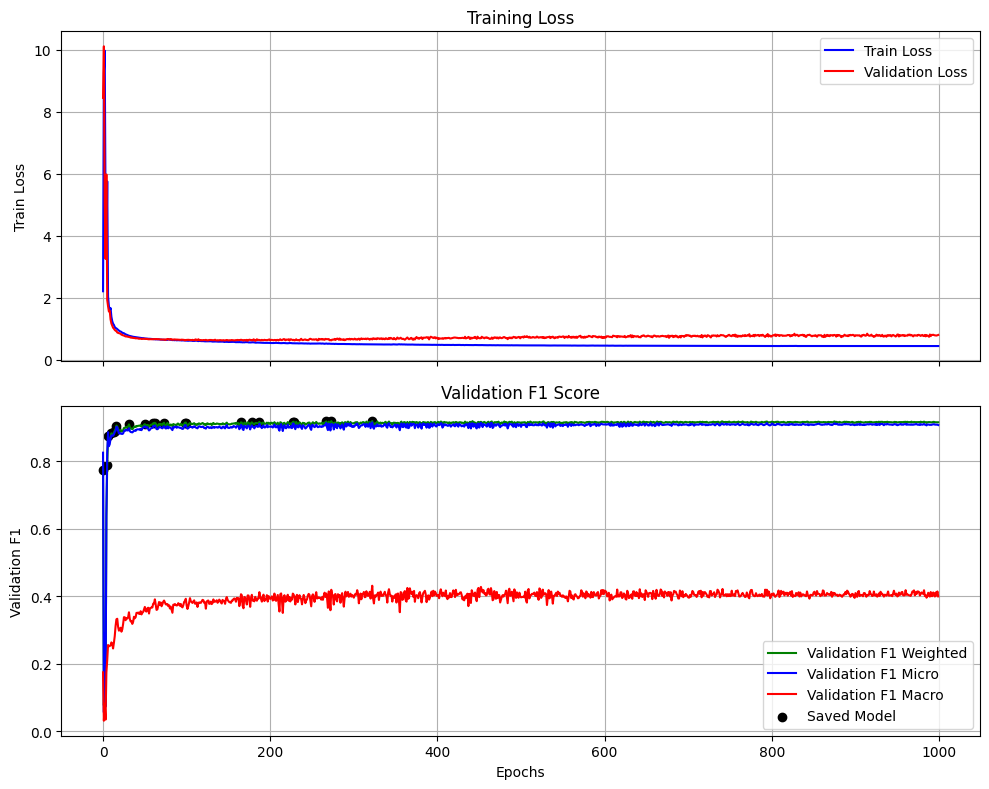

In [26]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [27]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  278
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_categorical_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.9145
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   73    47   158    40    12     0     0     1     0     0]
 [   55    52   133    25    14     2     0     3     3     0]
 [  141    56  1029   288    30    15     1    15     6     1]
 [  149   126  1356   804    95    44     3    77    52     5]
 [  105   120   181    58   382     3     0    19    15     2]
 [   15     2   159    82   107 15275     1    14    46     1]
 [   39     0    12    35   361     0 33052    25    38     9]
 [    8     2   199    59    39     8     3   150    17     5]
 [    0     1     0     4     0     0     0     1    29     0]
 [    0     0     0     2     3     0     0     0     0     1]]
                precision    recall  f1-score   support

      Analysis     0.1248    0.2205    0.1594       331
     Backdoors     0.1281    0.1812    0.1501       287
           DoS     0.3189    0.6504    0.4279      1582
   

In [28]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [29]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_categorical_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.8137
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 125   52  230  237 2117  872  862  265  730   70    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[    4    42   137    16    37     0    95     0     0     0]
 [    0    39   113     2    38     4    91     0     0     0]
 [   24    38   856   102    60    32   470     0     0     0]
 

In [30]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_categorical_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.8052
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  12    8   47  400  559   37 3608  130  668   91    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  115    12    17    41    40     0     6   100     0     0]
 [   89    12    17    31    37     7     1    93     0     0]
 [  449    14   125   197    39    46    35   677     0     0]
 

In [31]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [32]:
# Inject Random Nodes in the graph
injected_graph_dataset = [inject_random_nodes(g.cpu(), 0.1, num_injected_nodes=1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_categorical_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.8139
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  43   26  193  222  509  656 3473  127  262   49    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   89    25   148    33    14     0    12    10     0     0]
 [   80    27   127    15    16     2    11     8     1     0]
 [  162    37   939   218    35    19    86    83     3     0]
 